In [1]:
import torch
import sklearn
import numpy as np
import pandas as pd
from torch import nn
from torch.utils.data import DataLoader
import sklearn.datasets
import matplotlib.pyplot as plt
import sklearn.linear_model
import torch.functional as F

# In diesem Package ist das Neuronale Netz, Training, Test und Informed Loss Funktionen ausgelagert.
import ConcreteNeuralNetwork

# import dataset
from sklearn.model_selection import train_test_split
data = pd.read_csv("slump_test.csv")
X = torch.FloatTensor(data.iloc[:, 1:10].values)
y = torch.FloatTensor(data.iloc[:, 10].values)

means = X.mean(dim=0, keepdim=True)
stds = X.std(dim=0, keepdim=True)
X = (X - means) / stds

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.76, random_state=1)
print('Average: {}, Standard Deviation: {}'.format(means, stds))
data.head()

Average: tensor([[229.8942,  77.9738, 149.0146, 197.1680,   8.5398, 883.9785, 739.6048,
          18.0485,  49.6107]]), Standard Deviation: tensor([[78.8772, 60.4614, 85.4181, 20.2082,  2.8075, 88.3914, 63.3421,  8.7508,
         17.5686]])


,No,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,1,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99
1,2,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14
2,3,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81
3,4,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08
4,5,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82


# Neural Network

Train R2: 0.9292399226198987, Train RMSE: 2.0166423320770264
Test R2: 0.8412351055465553, Test RMSE: 3.2533504962921143


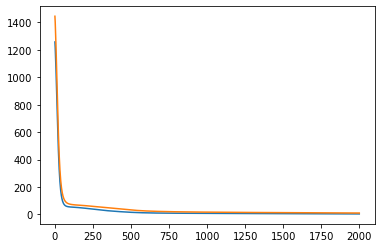

In [2]:
model = ConcreteNeuralNetwork.ConcreteNN()
loss_over_time, test_loss_over_time = ConcreteNeuralNetwork.train(model, X_train, y_train, X_test, y_test)

plt.figure()
plt.plot(loss_over_time)
plt.plot(test_loss_over_time)

test_r2, test_rmse = ConcreteNeuralNetwork.eval_model(model, X_test, y_test)
train_r2, train_rmse = ConcreteNeuralNetwork.eval_model(model, X_train, y_train)

print('Train R2: {}, Train RMSE: {}'.format(train_r2, train_rmse))
print('Test R2: {}, Test RMSE: {}'.format(test_r2, test_rmse))

In [7]:
# Netz mit 50 Zufallsinitialisierungen laufen lassen
test_r2_list = []
test_rmse_list = []
train_r2_list = []
train_rmse_list = []

for i in range(50):
    model = ConcreteNeuralNetwork.ConcreteNN()
    ConcreteNeuralNetwork.train(model, X_train, y_train, X_test, y_test)
    test_r2, test_rmse = ConcreteNeuralNetwork.eval_model(model, X_test, y_test)
    train_r2, train_rmse = ConcreteNeuralNetwork.eval_model(model, X_train, y_train)
    test_r2_list.append(test_r2)
    test_rmse_list.append(test_rmse)
    train_r2_list.append(train_r2)
    train_rmse_list.append(train_rmse)
    
print('Train R2: {}, Train RMSE: {}'.format(sum(train_r2_list)/50, sum(train_rmse_list)/50))
print('Test R2: {}, Test RMSE: {}'.format(sum(test_r2_list)/50, sum(test_rmse_list)/50))

Train R2: 0.934331993048516, Train RMSE: 1.9413718700408935
Test R2: 0.8528660032269638, Test RMSE: 3.131404185295105


Train R2: 0.9297702668562022, Train RMSE: 2.0570353627204896
Test R2: 0.8251438821659616, Test RMSE: 2.516061472892761


<ErrorbarContainer object of 3 artists>

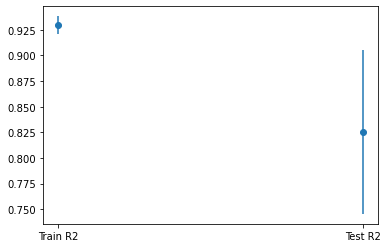

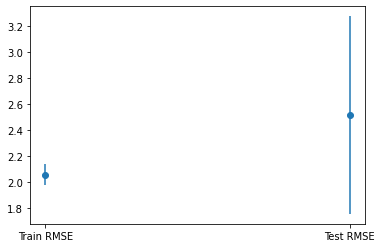

In [12]:
# 10-Fold Cross Validation
test_r2_list = []
test_rmse_list = []
train_r2_list = []
train_rmse_list = []
K = 10
skf = sklearn.model_selection.KFold(n_splits=K)
skf.get_n_splits(X, y)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.FloatTensor(y_train)
    y_test = torch.FloatTensor(y_test)

    model = ConcreteNeuralNetwork.ConcreteNN()
    ConcreteNeuralNetwork.train(model, X_train, y_train, X_test, y_test)
    
    test_r2, test_rmse = ConcreteNeuralNetwork.eval_model(model, X_test, y_test)
    train_r2, train_rmse = ConcreteNeuralNetwork.eval_model(model, X_train, y_train)

    test_r2_list.append(test_r2)
    test_rmse_list.append(test_rmse)
    train_r2_list.append(train_r2)
    train_rmse_list.append(train_rmse)

print('Train R2: {}, Train RMSE: {}'.format(sum(train_r2_list)/K, sum(train_rmse_list)/K))
print('Test R2: {}, Test RMSE: {}'.format(sum(test_r2_list)/K, sum(test_rmse_list)/K))

train_r2_mean = torch.mean(torch.FloatTensor(train_r2_list)).item()
train_r2_std = torch.std(torch.FloatTensor(train_r2_list)).item()
train_rmse_mean = torch.mean(torch.FloatTensor(train_rmse_list)).item()
train_rmse_std = torch.std(torch.FloatTensor(train_rmse_list)).item()
test_r2_mean = torch.mean(torch.FloatTensor(test_r2_list)).item()
test_r2_std = torch.std(torch.FloatTensor(test_r2_list)).item()
test_rmse_mean = torch.mean(torch.FloatTensor(test_rmse_list)).item()
test_rmse_std = torch.std(torch.FloatTensor(test_rmse_list)).item()

r2_names = ['Train R2', 'Test R2']
rmse_names = ['Train RMSE', 'Test RMSE']
plt.figure()
plt.errorbar(r2_names, [train_r2_mean, test_r2_mean], [train_r2_std, test_r2_std], linestyle='None', marker='o')
plt.figure()
plt.errorbar(rmse_names, [train_rmse_mean, test_rmse_mean], [train_rmse_std, test_rmse_std], linestyle='None', marker='o')


# Informed Machine Learning: Custom Loss Function

## Plot linear relationship

[35.595978  -0.9408999]


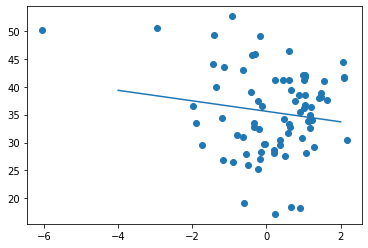

In [3]:
# Plot linear relationship between Water, Cement and Concrete Strength
W, b = ConcreteNeuralNetwork.linear_relationship(X_train, y_train)
print(b)
x_line = np.linspace(-4, 2, 100)
y_line = b[0] + b[1]*x_line

plt.scatter(W[:, 1], y_train)
plt.plot(x_line, y_line)

## Informed Loss 1

\begin{align}
InformedLoss = MSELoss(output, target) + \lambda\cdot ReLU(target - (b_0 + b_1\cdot w))
\end{align}

### Train with $\lambda$ = 0.1 once, plot statistics

Train R2: 0.912605382915494, Train RMSE: 2.2411818504333496
Test R2: 0.8352639144163603, Test RMSE: 3.3139657974243164


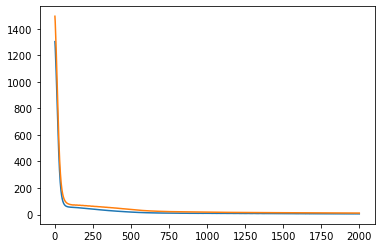

In [6]:
model = ConcreteNeuralNetwork.ConcreteNN()
# train with custom loss: 
#       Inputs: Custom Loss, lambda, X_train, y_train, X_test, y_test
#       Outputs: Loss and Test Loss over Time, Model Training
loss_over_time, test_loss_over_time = ConcreteNeuralNetwork.train_with_closs(model, ConcreteNeuralNetwork.informed_loss1, 0.1, X_train, y_train, X_test, y_test)

plt.figure()
plt.plot(loss_over_time)
plt.plot(test_loss_over_time)

test_r2, test_rmse = ConcreteNeuralNetwork.eval_model(model, X_test, y_test)
train_r2, train_rmse = ConcreteNeuralNetwork.eval_model(model, X_train, y_train)

print('Train R2: {}, Train RMSE: {}'.format(train_r2, train_rmse))
print('Test R2: {}, Test RMSE: {}'.format(test_r2, test_rmse))

### 10-Fold Cross Validation with $\lambda$ = 1, plot statistics
(Keine Kostenkurven hier)

Train R2: 0.9171558869502364, Train RMSE: 2.230756378173828
Test R2: 0.7892415006153649, Test RMSE: 2.7438304901123045


<ErrorbarContainer object of 3 artists>

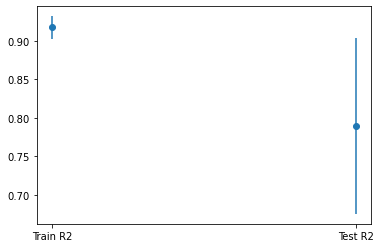

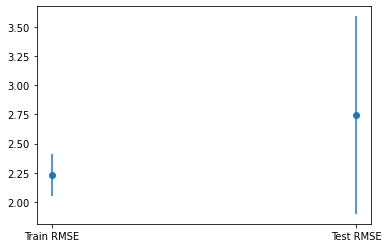

In [7]:
# 10-Fold Cross Validation
test_r2_list = []
test_rmse_list = []
train_r2_list = []
train_rmse_list = []
K = 10
lamb = 0.1

skf = sklearn.model_selection.KFold(n_splits=K)
skf.get_n_splits(X, y)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.FloatTensor(y_train)
    y_test = torch.FloatTensor(y_test)

    model = ConcreteNeuralNetwork.ConcreteNN()
    ConcreteNeuralNetwork.train_with_closs(model, ConcreteNeuralNetwork.informed_loss1, lamb, X_train, y_train, X_test, y_test)
    
    test_r2, test_rmse = ConcreteNeuralNetwork.eval_model(model, X_test, y_test)
    train_r2, train_rmse = ConcreteNeuralNetwork.eval_model(model, X_train, y_train)

    test_r2_list.append(test_r2)
    test_rmse_list.append(test_rmse)
    train_r2_list.append(train_r2)
    train_rmse_list.append(train_rmse)

print('Train R2: {}, Train RMSE: {}'.format(sum(train_r2_list)/K, sum(train_rmse_list)/K))
print('Test R2: {}, Test RMSE: {}'.format(sum(test_r2_list)/K, sum(test_rmse_list)/K))

train_r2_mean = torch.mean(torch.FloatTensor(train_r2_list)).item()
train_r2_std = torch.std(torch.FloatTensor(train_r2_list)).item()
train_rmse_mean = torch.mean(torch.FloatTensor(train_rmse_list)).item()
train_rmse_std = torch.std(torch.FloatTensor(train_rmse_list)).item()
test_r2_mean = torch.mean(torch.FloatTensor(test_r2_list)).item()
test_r2_std = torch.std(torch.FloatTensor(test_r2_list)).item()
test_rmse_mean = torch.mean(torch.FloatTensor(test_rmse_list)).item()
test_rmse_std = torch.std(torch.FloatTensor(test_rmse_list)).item()

r2_names = ['Train R2', 'Test R2']
rmse_names = ['Train RMSE', 'Test RMSE']
plt.figure()
plt.errorbar(r2_names, [train_r2_mean, test_r2_mean], [train_r2_std, test_r2_std], linestyle='None', marker='o')
plt.figure()
plt.errorbar(rmse_names, [train_rmse_mean, test_rmse_mean], [train_rmse_std, test_rmse_std], linestyle='None', marker='o')

### Train several values for $\lambda$ with 10-Fold CV.

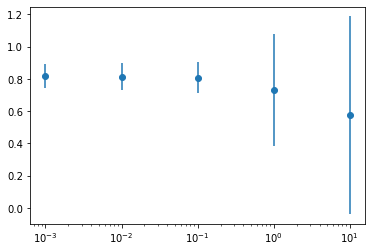

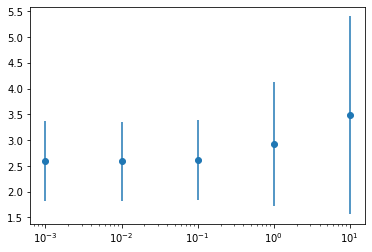

In [14]:
# 10-Fold Cross Validation
K = 10
lambdas = [0, 0.001, 0.01, 0.1, 1, 10]

test_r2_list = []
test_rmse_list = []
train_r2_list = []
train_rmse_list = []
train_r2_means = []
train_r2_stds = []
train_rmse_means = [] 
train_rmse_stds = []
test_r2_means = [] 
test_r2_stds = []
test_rmse_means = [] 
test_rmse_stds = []

skf = sklearn.model_selection.KFold(n_splits=K)
skf.get_n_splits(X, y)
for lamb in lambdas:
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train = torch.FloatTensor(X_train)
        X_test = torch.FloatTensor(X_test)
        y_train = torch.FloatTensor(y_train)
        y_test = torch.FloatTensor(y_test)

        model = ConcreteNeuralNetwork.ConcreteNN()
        ConcreteNeuralNetwork.train_with_closs(model, ConcreteNeuralNetwork.informed_loss1, lamb, X_train, y_train, X_test, y_test)
        
        test_r2, test_rmse = ConcreteNeuralNetwork.eval_model(model, X_test, y_test)
        train_r2, train_rmse = ConcreteNeuralNetwork.eval_model(model, X_train, y_train)

        test_r2_list.append(test_r2)
        test_rmse_list.append(test_rmse)
        train_r2_list.append(train_r2)
        train_rmse_list.append(train_rmse)

    train_r2_mean = torch.mean(torch.FloatTensor(train_r2_list)).item()
    train_r2_std = torch.std(torch.FloatTensor(train_r2_list)).item()
    train_rmse_mean = torch.mean(torch.FloatTensor(train_rmse_list)).item()
    train_rmse_std = torch.std(torch.FloatTensor(train_rmse_list)).item()
    test_r2_mean = torch.mean(torch.FloatTensor(test_r2_list)).item()
    test_r2_std = torch.std(torch.FloatTensor(test_r2_list)).item()
    test_rmse_mean = torch.mean(torch.FloatTensor(test_rmse_list)).item()
    test_rmse_std = torch.std(torch.FloatTensor(test_rmse_list)).item()
    
    train_r2_means.append(train_r2_mean)
    train_r2_stds.append(train_r2_std)
    train_rmse_means.append(train_rmse_mean)
    train_rmse_stds.append(train_rmse_std)
    test_r2_means.append(test_r2_mean)
    test_r2_stds.append(test_r2_std)
    test_rmse_means.append(test_rmse_mean) 
    test_rmse_stds.append(test_rmse_std)
    
plt.figure()
plt.errorbar(lambdas, test_r2_means, test_r2_stds, linestyle='None', marker='o')
plt.xscale('log')
plt.figure()
plt.errorbar(lambdas, test_rmse_means, test_rmse_stds, linestyle='None', marker='o')
plt.xscale('log')

## Informed Loss 2

\begin{align}
InformedLoss = MSELoss(output, target) + \lambda\cdot ReLU(|f - (b_0 + b_1\cdot w)|)
\end{align}

### Train with $\lambda$ = 0.1 once, plot statistics

Train R2: 0.8869126635257429, Train RMSE: 2.4820916652679443
Test R2: 0.6168090724997513, Test RMSE: 2.6511313915252686


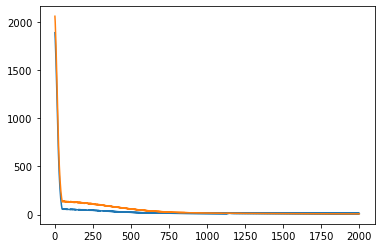

In [8]:
model = ConcreteNeuralNetwork.ConcreteNN()
# train with custom loss: 
#       Inputs: Custom Loss, lambda, X_train, y_train, X_test, y_test
#       Outputs: Loss and Test Loss over Time, Model Training
loss_over_time, test_loss_over_time = ConcreteNeuralNetwork.train_with_closs(model, ConcreteNeuralNetwork.informed_loss2, 0.1, X_train, y_train, X_test, y_test)

plt.figure()
plt.plot(loss_over_time)
plt.plot(test_loss_over_time)

test_r2, test_rmse = ConcreteNeuralNetwork.eval_model(model, X_test, y_test)
train_r2, train_rmse = ConcreteNeuralNetwork.eval_model(model, X_train, y_train)

print('Train R2: {}, Train RMSE: {}'.format(train_r2, train_rmse))
print('Test R2: {}, Test RMSE: {}'.format(test_r2, test_rmse))

### 10-Fold Cross Validation with $\lambda$ = 1, plot statistics
(Keine Kostenkurven hier)

Train R2: 0.912282729766091, Train RMSE: 2.2953068733215334
Test R2: 0.7805265912083615, Test RMSE: 2.7900069832801817


<ErrorbarContainer object of 3 artists>

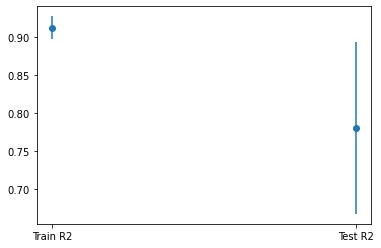

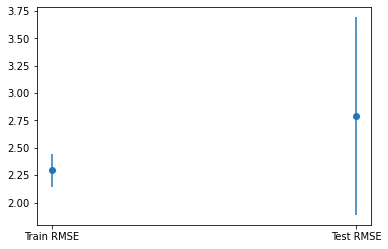

In [9]:
# 10-Fold Cross Validation
test_r2_list = []
test_rmse_list = []
train_r2_list = []
train_rmse_list = []
K = 10
lamb = 0.1

skf = sklearn.model_selection.KFold(n_splits=K)
skf.get_n_splits(X, y)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.FloatTensor(y_train)
    y_test = torch.FloatTensor(y_test)

    model = ConcreteNeuralNetwork.ConcreteNN()
    ConcreteNeuralNetwork.train_with_closs(model, ConcreteNeuralNetwork.informed_loss2, lamb, X_train, y_train, X_test, y_test)
    
    test_r2, test_rmse = ConcreteNeuralNetwork.eval_model(model, X_test, y_test)
    train_r2, train_rmse = ConcreteNeuralNetwork.eval_model(model, X_train, y_train)

    test_r2_list.append(test_r2)
    test_rmse_list.append(test_rmse)
    train_r2_list.append(train_r2)
    train_rmse_list.append(train_rmse)

print('Train R2: {}, Train RMSE: {}'.format(sum(train_r2_list)/K, sum(train_rmse_list)/K))
print('Test R2: {}, Test RMSE: {}'.format(sum(test_r2_list)/K, sum(test_rmse_list)/K))

train_r2_mean = torch.mean(torch.FloatTensor(train_r2_list)).item()
train_r2_std = torch.std(torch.FloatTensor(train_r2_list)).item()
train_rmse_mean = torch.mean(torch.FloatTensor(train_rmse_list)).item()
train_rmse_std = torch.std(torch.FloatTensor(train_rmse_list)).item()
test_r2_mean = torch.mean(torch.FloatTensor(test_r2_list)).item()
test_r2_std = torch.std(torch.FloatTensor(test_r2_list)).item()
test_rmse_mean = torch.mean(torch.FloatTensor(test_rmse_list)).item()
test_rmse_std = torch.std(torch.FloatTensor(test_rmse_list)).item()

r2_names = ['Train R2', 'Test R2']
rmse_names = ['Train RMSE', 'Test RMSE']
plt.figure()
plt.errorbar(r2_names, [train_r2_mean, test_r2_mean], [train_r2_std, test_r2_std], linestyle='None', marker='o')
plt.figure()
plt.errorbar(rmse_names, [train_rmse_mean, test_rmse_mean], [train_rmse_std, test_rmse_std], linestyle='None', marker='o')

### Train several values for $\lambda$ with 10-Fold CV.

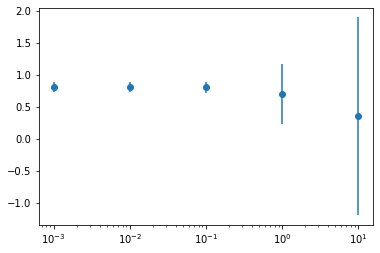

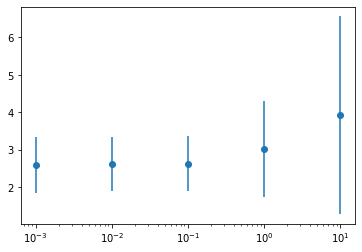

In [15]:
# 10-Fold Cross Validation
K = 10
lambdas = [0, 0.001, 0.01, 0.1, 1, 10]

test_r2_list = []
test_rmse_list = []
train_r2_list = []
train_rmse_list = []
train_r2_means = []
train_r2_stds = []
train_rmse_means = [] 
train_rmse_stds = []
test_r2_means = [] 
test_r2_stds = []
test_rmse_means = [] 
test_rmse_stds = []

skf = sklearn.model_selection.KFold(n_splits=K)
skf.get_n_splits(X, y)
for lamb in lambdas:
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train = torch.FloatTensor(X_train)
        X_test = torch.FloatTensor(X_test)
        y_train = torch.FloatTensor(y_train)
        y_test = torch.FloatTensor(y_test)

        model = ConcreteNeuralNetwork.ConcreteNN()
        ConcreteNeuralNetwork.train_with_closs(model, ConcreteNeuralNetwork.informed_loss2, lamb, X_train, y_train, X_test, y_test)
        
        test_r2, test_rmse = ConcreteNeuralNetwork.eval_model(model, X_test, y_test)
        train_r2, train_rmse = ConcreteNeuralNetwork.eval_model(model, X_train, y_train)

        test_r2_list.append(test_r2)
        test_rmse_list.append(test_rmse)
        train_r2_list.append(train_r2)
        train_rmse_list.append(train_rmse)

    train_r2_mean = torch.mean(torch.FloatTensor(train_r2_list)).item()
    train_r2_std = torch.std(torch.FloatTensor(train_r2_list)).item()
    train_rmse_mean = torch.mean(torch.FloatTensor(train_rmse_list)).item()
    train_rmse_std = torch.std(torch.FloatTensor(train_rmse_list)).item()
    test_r2_mean = torch.mean(torch.FloatTensor(test_r2_list)).item()
    test_r2_std = torch.std(torch.FloatTensor(test_r2_list)).item()
    test_rmse_mean = torch.mean(torch.FloatTensor(test_rmse_list)).item()
    test_rmse_std = torch.std(torch.FloatTensor(test_rmse_list)).item()
    
    train_r2_means.append(train_r2_mean)
    train_r2_stds.append(train_r2_std)
    train_rmse_means.append(train_rmse_mean)
    train_rmse_stds.append(train_rmse_std)
    test_r2_means.append(test_r2_mean)
    test_r2_stds.append(test_r2_std)
    test_rmse_means.append(test_rmse_mean) 
    test_rmse_stds.append(test_rmse_std)
    
plt.figure()
plt.errorbar(lambdas, test_r2_means, test_r2_stds, linestyle='None', marker='o')
plt.xscale('log')
plt.figure()
plt.errorbar(lambdas, test_rmse_means, test_rmse_stds, linestyle='None', marker='o')
plt.xscale('log')

## InformedLoss 3


\begin{align}
InformedLoss = MSELoss(output, target) + \lambda\cdot|f - (b_0 + b_1\cdot w)|
\end{align}

### Train with $\lambda$ = 0.1 once, plot statistics

Train R2: 0.8939559673010351, Train RMSE: 2.4035539627075195
Test R2: 0.6115649616724229, Test RMSE: 2.66921067237854


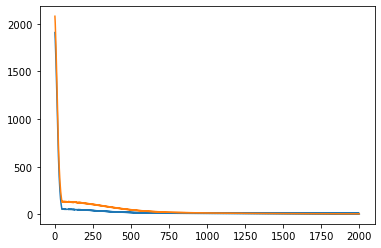

In [18]:
model = ConcreteNeuralNetwork.ConcreteNN()
# train with custom loss: 
#       Inputs: Custom Loss, lambda, X_train, y_train, X_test, y_test
#       Outputs: Loss and Test Loss over Time, Model Training
loss_over_time, test_loss_over_time = ConcreteNeuralNetwork.train_with_closs(model, ConcreteNeuralNetwork.informed_loss3, 0.1, X_train, y_train, X_test, y_test)

plt.figure()
plt.plot(loss_over_time)
plt.plot(test_loss_over_time)

test_r2, test_rmse = ConcreteNeuralNetwork.eval_model(model, X_test, y_test)
train_r2, train_rmse = ConcreteNeuralNetwork.eval_model(model, X_train, y_train)

print('Train R2: {}, Train RMSE: {}'.format(train_r2, train_rmse))
print('Test R2: {}, Test RMSE: {}'.format(test_r2, test_rmse))

### 10-Fold Cross Validation with $\lambda$ = 1, plot statistics
(Keine Kostenkurven hier)

Train R2: 0.9158640383468682, Train RMSE: 2.248915457725525
Test R2: 0.7970601458565738, Test RMSE: 2.7005853772163393


<ErrorbarContainer object of 3 artists>

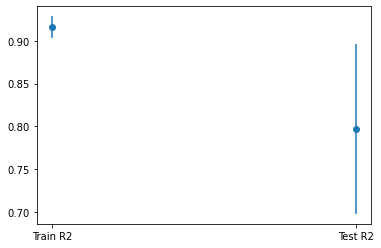

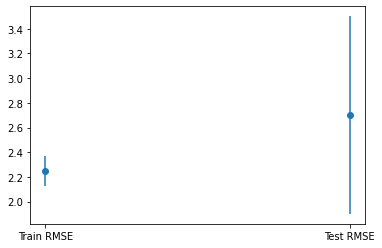

In [17]:
# 10-Fold Cross Validation
test_r2_list = []
test_rmse_list = []
train_r2_list = []
train_rmse_list = []
K = 10
lamb = 0.1

skf = sklearn.model_selection.KFold(n_splits=K)
skf.get_n_splits(X, y)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.FloatTensor(y_train)
    y_test = torch.FloatTensor(y_test)

    model = ConcreteNeuralNetwork.ConcreteNN()
    ConcreteNeuralNetwork.train_with_closs(model, ConcreteNeuralNetwork.informed_loss2, lamb, X_train, y_train, X_test, y_test)
    
    test_r2, test_rmse = ConcreteNeuralNetwork.eval_model(model, X_test, y_test)
    train_r2, train_rmse = ConcreteNeuralNetwork.eval_model(model, X_train, y_train)

    test_r2_list.append(test_r2)
    test_rmse_list.append(test_rmse)
    train_r2_list.append(train_r2)
    train_rmse_list.append(train_rmse)

print('Train R2: {}, Train RMSE: {}'.format(sum(train_r2_list)/K, sum(train_rmse_list)/K))
print('Test R2: {}, Test RMSE: {}'.format(sum(test_r2_list)/K, sum(test_rmse_list)/K))

train_r2_mean = torch.mean(torch.FloatTensor(train_r2_list)).item()
train_r2_std = torch.std(torch.FloatTensor(train_r2_list)).item()
train_rmse_mean = torch.mean(torch.FloatTensor(train_rmse_list)).item()
train_rmse_std = torch.std(torch.FloatTensor(train_rmse_list)).item()
test_r2_mean = torch.mean(torch.FloatTensor(test_r2_list)).item()
test_r2_std = torch.std(torch.FloatTensor(test_r2_list)).item()
test_rmse_mean = torch.mean(torch.FloatTensor(test_rmse_list)).item()
test_rmse_std = torch.std(torch.FloatTensor(test_rmse_list)).item()

r2_names = ['Train R2', 'Test R2']
rmse_names = ['Train RMSE', 'Test RMSE']
plt.figure()
plt.errorbar(r2_names, [train_r2_mean, test_r2_mean], [train_r2_std, test_r2_std], linestyle='None', marker='o')
plt.figure()
plt.errorbar(rmse_names, [train_rmse_mean, test_rmse_mean], [train_rmse_std, test_rmse_std], linestyle='None', marker='o')

### Train several values for $\lambda$ with 10-Fold CV.

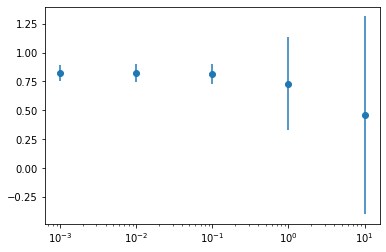

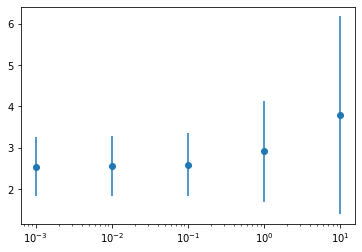

In [16]:
# 10-Fold Cross Validation
K = 10
lambdas = [0, 0.001, 0.01, 0.1, 1, 10]

test_r2_list = []
test_rmse_list = []
train_r2_list = []
train_rmse_list = []
train_r2_means = []
train_r2_stds = []
train_rmse_means = [] 
train_rmse_stds = []
test_r2_means = [] 
test_r2_stds = []
test_rmse_means = [] 
test_rmse_stds = []

skf = sklearn.model_selection.KFold(n_splits=K)
skf.get_n_splits(X, y)
for lamb in lambdas:
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train = torch.FloatTensor(X_train)
        X_test = torch.FloatTensor(X_test)
        y_train = torch.FloatTensor(y_train)
        y_test = torch.FloatTensor(y_test)

        model = ConcreteNeuralNetwork.ConcreteNN()
        ConcreteNeuralNetwork.train_with_closs(model, ConcreteNeuralNetwork.informed_loss3, lamb, X_train, y_train, X_test, y_test)
        
        test_r2, test_rmse = ConcreteNeuralNetwork.eval_model(model, X_test, y_test)
        train_r2, train_rmse = ConcreteNeuralNetwork.eval_model(model, X_train, y_train)

        test_r2_list.append(test_r2)
        test_rmse_list.append(test_rmse)
        train_r2_list.append(train_r2)
        train_rmse_list.append(train_rmse)

    train_r2_mean = torch.mean(torch.FloatTensor(train_r2_list)).item()
    train_r2_std = torch.std(torch.FloatTensor(train_r2_list)).item()
    train_rmse_mean = torch.mean(torch.FloatTensor(train_rmse_list)).item()
    train_rmse_std = torch.std(torch.FloatTensor(train_rmse_list)).item()
    test_r2_mean = torch.mean(torch.FloatTensor(test_r2_list)).item()
    test_r2_std = torch.std(torch.FloatTensor(test_r2_list)).item()
    test_rmse_mean = torch.mean(torch.FloatTensor(test_rmse_list)).item()
    test_rmse_std = torch.std(torch.FloatTensor(test_rmse_list)).item()
    
    train_r2_means.append(train_r2_mean)
    train_r2_stds.append(train_r2_std)
    train_rmse_means.append(train_rmse_mean)
    train_rmse_stds.append(train_rmse_std)
    test_r2_means.append(test_r2_mean)
    test_r2_stds.append(test_r2_std)
    test_rmse_means.append(test_rmse_mean) 
    test_rmse_stds.append(test_rmse_std)
    
plt.figure()
plt.errorbar(lambdas, test_r2_means, test_r2_stds, linestyle='None', marker='o')
plt.xscale('log')
plt.figure()
plt.errorbar(lambdas, test_rmse_means, test_rmse_stds, linestyle='None', marker='o')
plt.xscale('log')